<a href="https://colab.research.google.com/github/RizalAkbarFitrianto/Klasifikasi-Tweet-Sarkasme-BERT/blob/main/Klasifikasi_Tweet_Sarkasme_IndoRoBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
!nvidia-smi

Wed Jan 10 05:37:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# !rm -r indonlu

In [4]:
!git clone https://github.com/ezaaputra/indonlu.git

Cloning into 'indonlu'...
remote: Enumerating objects: 460, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 460 (delta 119), reused 108 (delta 108), pack-reused 312
Receiving objects: 100% (460/460), 4.83 MiB | 10.08 MiB/s, done.
Resolving deltas: 100% (229/229), done.


# 1. Import Library

In [5]:
!pip install emoji
!pip install Sastrawi
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.8 MB/s eta 0:00:00


In [7]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

# NLP
import nltk
nltk.download('punkt')
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import emoji

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud

#Model IndoRoBERTa
import random
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm

# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="w11wo/indonesian-roberta-base-sentiment-classifier")

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/808k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/467k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

# 2. Exploratory Data Analysis

In [11]:
df_path = 'sarkasme-done.tsv'
stopword_path = 'stopword.txt'
kamus_alay_path = 'kamus_alay.csv'

In [12]:
# Import data
df = pd.read_csv(df_path, sep='\t', names=['review_text', 'category'])

In [13]:
df.sample(5)

,review_text,category
3883,terima kasih aksi damai people power kedaulata...,negative
439,ribuan orang berjuang keluarganya kerja honore...,negative
2534,jihaaddd jaahaaaddd ... ya jabbar ya qohhar #t...,negative
7800,@USER gelar dokter. usia dewasa. lemah pendek,positive
7336,"berjaya zulkifli hasan, tahan korupnya meluas....",positive


In [14]:
print(f'shape: {df.shape}')

shape: (8700, 2)


## Proporsi Variabel Target

In [15]:
df['category'].value_counts()

negative    4350
positive    4350
Name: category, dtype: int64

In [16]:
# Function to make a donut chart
def donut(sizes, ax, angle=90, labels=None,colors=None, explode=None, shadow=None):

    # Plot
    ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%',
           startangle = angle, pctdistance=0.8, explode = explode,
           wedgeprops=dict(width=0.4), shadow=shadow)

    # Formatting
    plt.axis('equal')
    plt.tight_layout()

In [17]:
# Plot arguments
sizes = df.category.value_counts()
labels = ['netral', 'sarkas']
colors = ['lightgreen', 'lightcoral']
explode = (0,0)

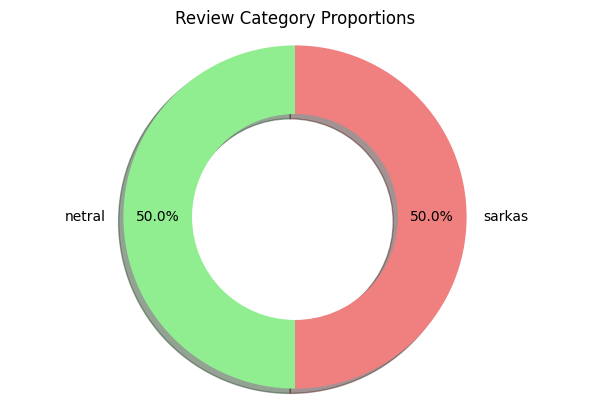

In [18]:
# Create axes
f, ax = plt.subplots(figsize=(6,4))

# plplotot donut
donut(sizes, ax, 90, labels, colors=colors, explode=explode, shadow=True)
ax.set_title('Review Category Proportions')

plt.show()

# 3. PreProcessing

## Preprocessing Tahap 1

In [19]:
character = ['.',',',';',':','-,','...','?','!','(',')','[',']','{','}','<','>','"','/','\'','#','-','@',
             'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# hapus karakter yang berulang
def repeatcharClean(text):
  for i in range(len(character)):
    charac_long = 5
    while charac_long > 2:
      char = character[i]*charac_long
      text = text.replace(char,character[i])
      charac_long -= 1
  return text

In [20]:
def clean_review(text):
  # ubah text menjadi huruf kecil
  text = text.lower()
  # ubah enter menjadi spasi
  text = re.sub(r'\n', ' ', text)
  # hapus emoji
  text = emoji.demojize(text)
  text = re.sub(':[A-Za-z_-]+:', ' ', text) # delete emoji
  # hapus emoticon
  text = re.sub(r"([xX;:]'?[dDpPvVoO3)(])", ' ', text)
  # hapus link
  text = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", text)
  # hapus usename
  text = re.sub(r"@[^\s]+[\s]?", ' ', text)
  # hapus hashtag
  text = re.sub(r'#(\S+)', r'\1', text)
  # hapus angka dan beberapa simbol
  text = re.sub('[^a-zA-Z,.?!]+',' ',text)
  # hapus karakter berulang
  text = repeatcharClean(text)
  # clear spasi
  text = re.sub('[ ]+',' ',text)
  return text

In [21]:
def preprocess_v1(df):
  df_pp = df.copy()
  df_pp.review_text = df_pp.review_text.map(clean_review)

  # delete empty row
  df_pp.review_text.replace('', np.nan, inplace=True)
  df_pp.review_text.replace(' ', np.nan, inplace=True)
  df_pp.dropna(subset=['review_text'], inplace=True)
  return df_pp

In [22]:
df_v1 = preprocess_v1(df)

In [ ]:
# export to tsv
# df_v1.to_csv('df_v1.tsv', sep='\t', header=None, index=False)

## Preprocessing Tahap 2

In [23]:
# additional_stopword:list kata tdk penting
additional_stop = [] #['ya', 'deh', 'dia']
# default stopword
default_stop = pd.read_csv(stopword_path, sep='\t', names=['stopwords'])
default_stop = default_stop.stopwords.to_list()
# combine all stopword
list_stopwords = []
list_stopwords = default_stop + additional_stop
# remove specific stopword
# list_stopwords.remove("sangat")
# list_stopwords.remove("sekali")

In [24]:
kamus_alay = pd.read_csv(kamus_alay_path)

normalize_word_dict = {}
for index, row in kamus_alay.iterrows():
    if row[0] not in normalize_word_dict:
        normalize_word_dict[row[0]] = row[1]

In [25]:
def normalize_review(text):
  # tokenize
  list_text = word_tokenize(text)
  # ubah bahasa alay
  list_text = [normalize_word_dict[term] if term in normalize_word_dict else term for term in list_text]
  # stemming
  # factory = StemmerFactory()
  # stemmer = factory.create_stemmer()
  # list_text = [stemmer.stem(word) for word in list_text]
  # hapus kata yang termasuk stopword
  # list_text = [word for word in list_text if word not in list_stopwords]
  # gabung kembali kalimat
  text = " ".join(list_text)
  return text

In [26]:
def preprocess_v2(df):
  df_pp = df.copy()
  df_pp.review_text = df_pp.review_text.map(normalize_review)

  # delete empty row
  df_pp.review_text.replace('', np.nan, inplace=True)
  df_pp.review_text.replace(' ', np.nan, inplace=True)
  df_pp.dropna(subset=['review_text'], inplace=True)
  return df_pp

In [27]:
# take a while
df_v2  = preprocess_v2(df_v1)

In [ ]:
# export to tsv
# df_v2.to_csv('df_v2.tsv', sep='\t', header=None, index=False)

In [28]:
def make_corpus(column):

    corpus_list = []

    for text in column:
        cleaned_list = text.split(' ')
        corpus_list.extend(cleaned_list)

    # transform list of words into 1 body of text
    corpus = ' '.join(corpus_list)
    corpus = re.sub('[ ]+',' ',corpus) # replace double whitespace with one

    return corpus

In [29]:
# Takes a while
corpus = make_corpus(df_v2.review_text)

In [30]:
# counting unique words
corpus_set = set(corpus.split(' '))

print(f'Count of unique words in corpus: {len(corpus_set)}')

Count of unique words in corpus: 11193


In [31]:
# function for freqdist
def word_freq(corpus, top=5):
    tokenized_word = word_tokenize(corpus)
    freqdist = FreqDist(tokenized_word)
    freqdist = freqdist.most_common(top) # list of tuples

    # decompose into label and frequency
    label = [tup[0] for tup in freqdist]
    freq = [tup[1] for tup in freqdist]
    df = pd.DataFrame({'word':label, 'freq':freq})

    return df

In [32]:
corpus_freq = word_freq(corpus, top=20)

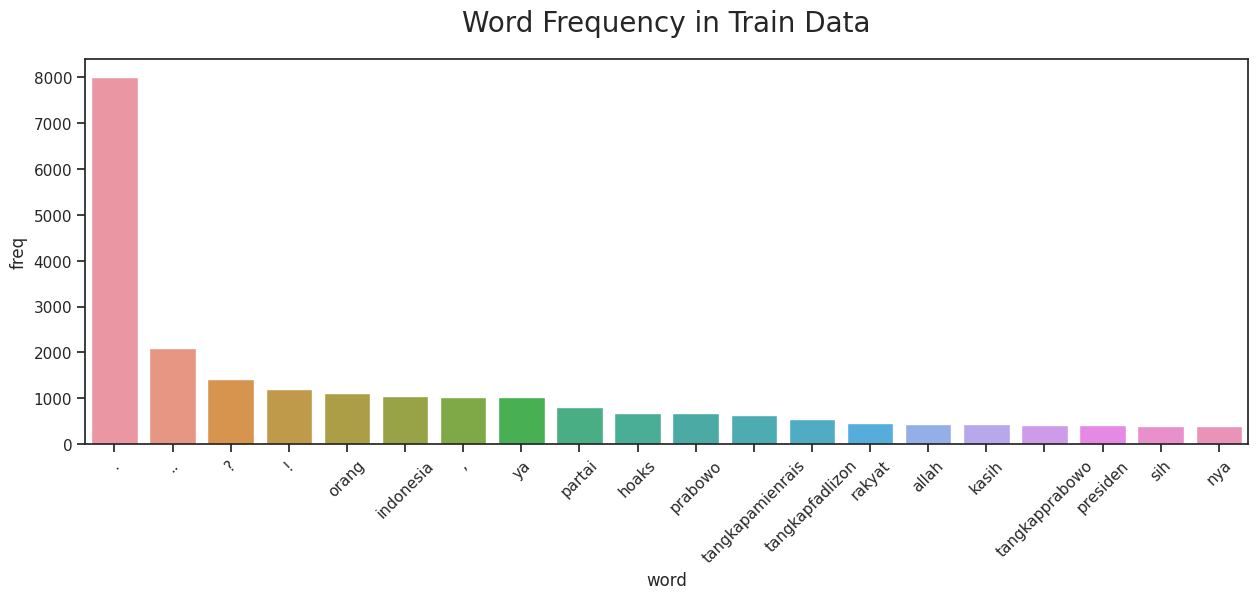

In [33]:
# Config params
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Compare plots of train and test corpus
f, ax1 = plt.subplots(1,figsize=(15,5))

sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax1)
ax1.set_title('Word Frequency in Train Data')
ax1.tick_params(axis='x', rotation=45)

# sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax2)
# ax2.set_title('Word Frequency in Train Data')
# ax2.tick_params(axis='x', rotation=45)

# sns.despine(ax=ax1)
# sns.despine(ax=ax2)
plt.show()

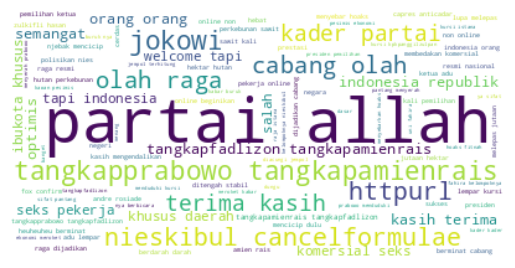

In [34]:
# Cloud for corpus
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# 4. Splitting

In [35]:
# train val split
train_set, val_set = train_test_split(df_v2, test_size=0.3, stratify=df_v2.category, random_state=1)
val_set, test_set = train_test_split(val_set, test_size=0.33, stratify=val_set.category, random_state=1)

In [36]:
print(f'Train shape: {train_set.shape}')
print(f'Val shape: {val_set.shape}')
print(f'Test shape: {test_set.shape}')

Train shape: (6088, 2)
Val shape: (1748, 2)
Test shape: (862, 2)


In [37]:
# export to tsv
train_set.to_csv('train_set.tsv', sep='\t', header=None, index=False)
val_set.to_csv('val_set.tsv', sep='\t', header=None, index=False)
test_set.to_csv('test_set.tsv', sep='\t', header=None, index=False)

# 5. Modeling

## a. Finetuning IndoBERT

In [38]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [39]:
# Set random seed
set_seed(27)

## b. Load Model IndoRoBERTa

In [40]:
# Load Tokenizer and Config
#tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
#config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
#config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
#model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

# Load model IndoRoBERTa directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("w11wo/indonesian-roberta-base-sentiment-classifier")
model = AutoModelForSequenceClassification.from_pretrained("w11wo/indonesian-roberta-base-sentiment-classifier")

In [ ]:
# Struktur model
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [41]:
count_param(model)

124647939

## c. Prepare Dataset

In [42]:
train_dataset_path = '/content/train_set.tsv'
valid_dataset_path = '/content/val_set.tsv'
test_dataset_path = '/content/test_set.tsv'

In [43]:
# fungsi dataset loader dari utils IndoNLU
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [44]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i) #word to index
print(i2w) #index to word

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


## d. Uji coba pre-trained model

In [45]:
text = 'adem berbalik solo habitat mu'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: adem berbalik solo habitat mu | Label : neutral (82.536%)


In [46]:
text = 'adem berbalik solo habitat mu'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: adem berbalik solo habitat mu | Label : neutral (82.536%)


In [47]:
text = 'adem berbalik solo habitat mu'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: adem berbalik solo habitat mu | Label : neutral (82.536%)


## e. Fine Tuning & Prediksi Evaluation

In [48]:
# Tentukan optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

### Training

In [49]:
# Train
n_epochs = 5
history = defaultdict(list)
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp_train, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Hitung skor train metrics
        list_hyp_train += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    metrics = document_sentiment_metrics_fn(list_hyp_train, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # save train acc for learning curve
    history['train_acc'].append(metrics['ACC'])

    # Evaluate di validation set
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Hitung total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Hitung skor evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))

    # save validation acc for learning curve
    history['val_acc'].append(metrics['ACC'])

  0%|          | 0/191 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 1) TRAIN LOSS:0.8954 LR:0.00000300: 100%|██████████| 191/191 [00:50<00:00,  3.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(Epoch 1) TRAIN LOSS:0.8954 ACC:0.64 F1:0.43 REC:0.43 PRE:0.43 LR:0.00000300


  0%|          | 0/55 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.4212 ACC:0.82 F1:0.82 REC:0.82 PRE:0.82: 100%|██████████| 55/55 [00:06<00:00,  8.25it/s]


(Epoch 1) VALID LOSS:0.4212 ACC:0.82 F1:0.82 REC:0.82 PRE:0.82


  0%|          | 0/191 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 2) TRAIN LOSS:0.4047 LR:0.00000300: 100%|██████████| 191/191 [00:53<00:00,  3.57it/s]


(Epoch 2) TRAIN LOSS:0.4047 ACC:0.82 F1:0.82 REC:0.82 PRE:0.82 LR:0.00000300


  0%|          | 0/55 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.2768 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89: 100%|██████████| 55/55 [00:06<00:00,  8.11it/s]


(Epoch 2) VALID LOSS:0.2768 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89


  0%|          | 0/191 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 3) TRAIN LOSS:0.2773 LR:0.00000300: 100%|██████████| 191/191 [00:54<00:00,  3.52it/s]


(Epoch 3) TRAIN LOSS:0.2773 ACC:0.89 F1:0.89 REC:0.89 PRE:0.89 LR:0.00000300


  0%|          | 0/55 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.1996 ACC:0.93 F1:0.93 REC:0.93 PRE:0.93: 100%|██████████| 55/55 [00:06<00:00,  7.87it/s]


(Epoch 3) VALID LOSS:0.1996 ACC:0.93 F1:0.93 REC:0.93 PRE:0.93


  0%|          | 0/191 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 4) TRAIN LOSS:0.2133 LR:0.00000300: 100%|██████████| 191/191 [00:54<00:00,  3.50it/s]


(Epoch 4) TRAIN LOSS:0.2133 ACC:0.92 F1:0.92 REC:0.92 PRE:0.92 LR:0.00000300


  0%|          | 0/55 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.1774 ACC:0.94 F1:0.94 REC:0.94 PRE:0.94: 100%|██████████| 55/55 [00:07<00:00,  7.58it/s]


(Epoch 4) VALID LOSS:0.1774 ACC:0.94 F1:0.94 REC:0.94 PRE:0.94


  0%|          | 0/191 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 5) TRAIN LOSS:0.1629 LR:0.00000300: 100%|██████████| 191/191 [00:54<00:00,  3.52it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(Epoch 5) TRAIN LOSS:0.1629 ACC:0.94 F1:0.63 REC:0.63 PRE:0.63 LR:0.00000300


  0%|          | 0/55 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.1737 ACC:0.94 F1:0.94 REC:0.94 PRE:0.94: 100%|██████████| 55/55 [00:06<00:00,  8.20it/s]

(Epoch 5) VALID LOSS:0.1737 ACC:0.94 F1:0.94 REC:0.94 PRE:0.94


### Learning Curve

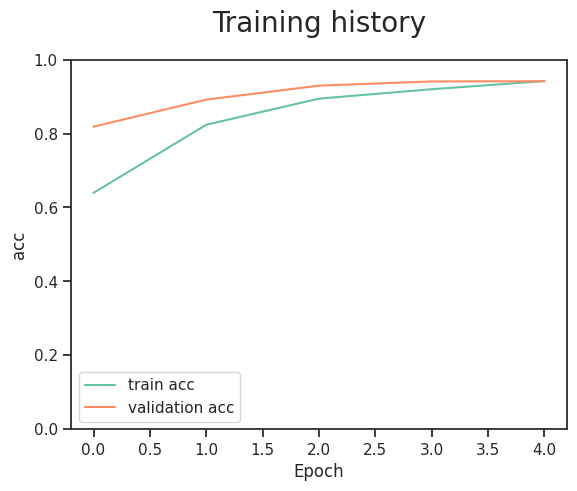

In [50]:
plt.plot(history['train_acc'], label='train acc')
plt.plot(history['val_acc'], label='validation acc')
plt.title('Training history')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [51]:
# Simpan Hasil Prediksi Validation Set
val_df = pd.read_csv(valid_dataset_path, sep='\t', names=['review_text', 'category'])
val_df['pred'] = list_hyp
val_df.head()
val_df.to_csv('val result.csv', index=False)

## f. Prediksi Test Set

In [52]:
# Prediksi test set
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
pred, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    pred += batch_hyp

  0%|          | 0/27 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 27/27 [00:03<00:00,  6.80it/s]


In [53]:
# Simpan prediksi test set
test_df = pd.read_csv(test_dataset_path, sep='\t', names=['review_text', 'category'])
test_df['pred'] = pred
test_df.head()
test_df.to_csv('test result.csv', index=False)

## e. Test fine-tuned model on sample sentences

In [54]:
text = 'adem berbalik solo habitat mu'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: adem berbalik solo habitat mu | Label : positive (97.086%)


In [55]:
text = 'menyimpang penampilan anies menciptakan lokasi surfing jalanan kota'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: menyimpang penampilan anies menciptakan lokasi surfing jalanan kota | Label : positive (99.326%)


In [56]:
text = 'hujan mulu kapan panasnya'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: hujan mulu kapan panasnya | Label : negative (99.706%)


# 6. Evaluasi

In [57]:
val_real = val_df.category
val_pred = val_df.pred

test_real = test_df.category
test_pred = test_df.pred

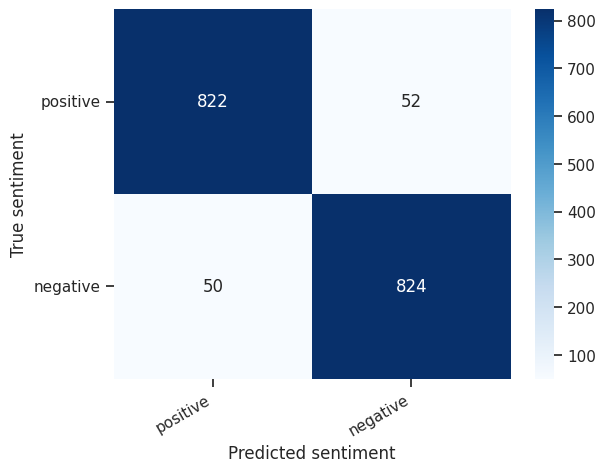

In [58]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(val_real, val_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'negative'], columns=['positive', 'negative'])
show_confusion_matrix(df_cm)

In [59]:
print(classification_report(val_real, val_pred, target_names=['positive', 'negative']))

              precision    recall  f1-score   support

    positive       0.94      0.94      0.94       874
    negative       0.94      0.94      0.94       874

    accuracy                           0.94      1748
   macro avg       0.94      0.94      0.94      1748
weighted avg       0.94      0.94      0.94      1748



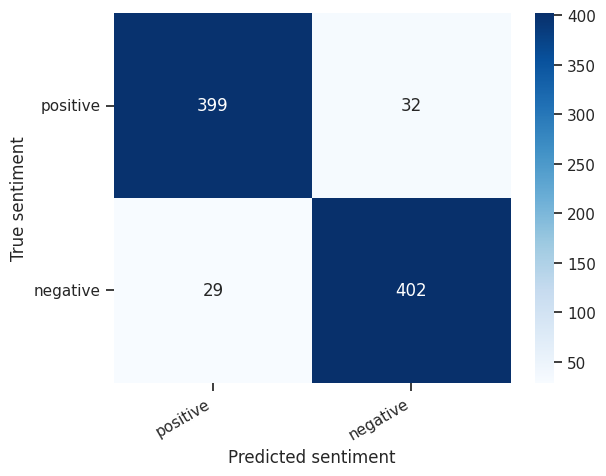

In [60]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(test_real, test_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'negative'], columns=['positive', 'negative'])
show_confusion_matrix(df_cm)

In [61]:
print(classification_report(test_real, test_pred, target_names=['positive', 'negative']))

              precision    recall  f1-score   support

    positive       0.93      0.93      0.93       431
    negative       0.93      0.93      0.93       431

    accuracy                           0.93       862
   macro avg       0.93      0.93      0.93       862
weighted avg       0.93      0.93      0.93       862

